<a href="https://colab.research.google.com/github/jjgranadat/Semillero_SOFA/blob/C%C3%A9sar/knn_svm_kmeans_16qam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.io import loadmat

## Globales

In [ ]:
def download_file(link):
    # Nombre del archivo
    file = link.split('/')[-1]
    
    # Descarga el archivo si no se ha hecho aún
    !if ! [[ -f "$file" ]]; then wget $link; fi;

    return file


# Función especial para leer todos los datos con la estructura estudiada
def read_data(folder_rx):
    data = {}

    # Leer la carpeta principal
    for folder in os.listdir(folder_rx):
        # Leer las subcarpetas
        if folder.endswith("spacing"):
            data[folder] = {}
            for file in os.listdir(f"{folder_rx}/{folder}"):
                if file.find("consY") != -1:
                    data_name = file.split("_")[2]
                    if data[folder].get(data_name) == None:
                        data[folder][data_name] = {}
                    mat_file_data = loadmat(f"{folder_rx}/{folder}/{file}")
                    data[folder][data_name] = mat_file_data
    return data

## Librería de funciones

In [ ]:
#LIB_LINK = "https://raw.githubusercontent.com/jjgranadat/Semillero_SOFA/C%C3%A9sar/sofa.py"
#LIB_FILE = download_file(LIB_LINK)
import sofa

## Datos experimentales

In [ ]:
# Enlace del archivo (raw)
# link_rx = "https://github.com/jjgranadat/Semillero_SOFA/raw/main/16QAM_3x16GBd_consY250km_00010.mat"
# link_tx = "https://github.com/jjgranadat/Semillero_SOFA/raw/main/2x16QAM_16GBd.mat"

# file_rx = download_file(link_rx)
# X_ch_norm = loadmat(file_rx)
# print(f"Las llaves de X_ch son: {X_ch_norm.keys()}")
# X_ch_norm = X_ch_norm.get("const_Y").flatten()
# X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm
# print(f"El tamaño de X_ch es: {X_ch_norm.shape}")

# file_tx = download_file(link_tx)
# X_tx_norm = loadmat(file_tx)
# print(f"Las llaves de X_tx son: {X_tx_norm.keys()}")
# X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][1].flatten()
# X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm
# print(f"El tamaño de X_tx es: {X_tx_norm.shape}")

In [ ]:
file_tx = "Datos/2x16QAM_16GBd.mat"
folder_rx = "Datos/"

# Datos transmitidos
X_tx_norm = loadmat(file_tx)
X_tx_norm = X_tx_norm.get("Constellation").flatten()[0][0].flatten()
X_tx = sofa.mod_norm(X_tx_norm, 10)*X_tx_norm

# Leer los datos recibidos
data = read_data(folder_rx)

## Demodulación usando KMeans

SNR 18dB terminado.
SNR 19dB terminado.
SNR 20dB terminado.
SNR 23dB terminado.
SNR 25dB terminado.
SNR 27dB terminado.
SNR 30dB terminado.
SNR 32dB terminado.
SNR 35dB terminado.
SNR 40dB terminado.


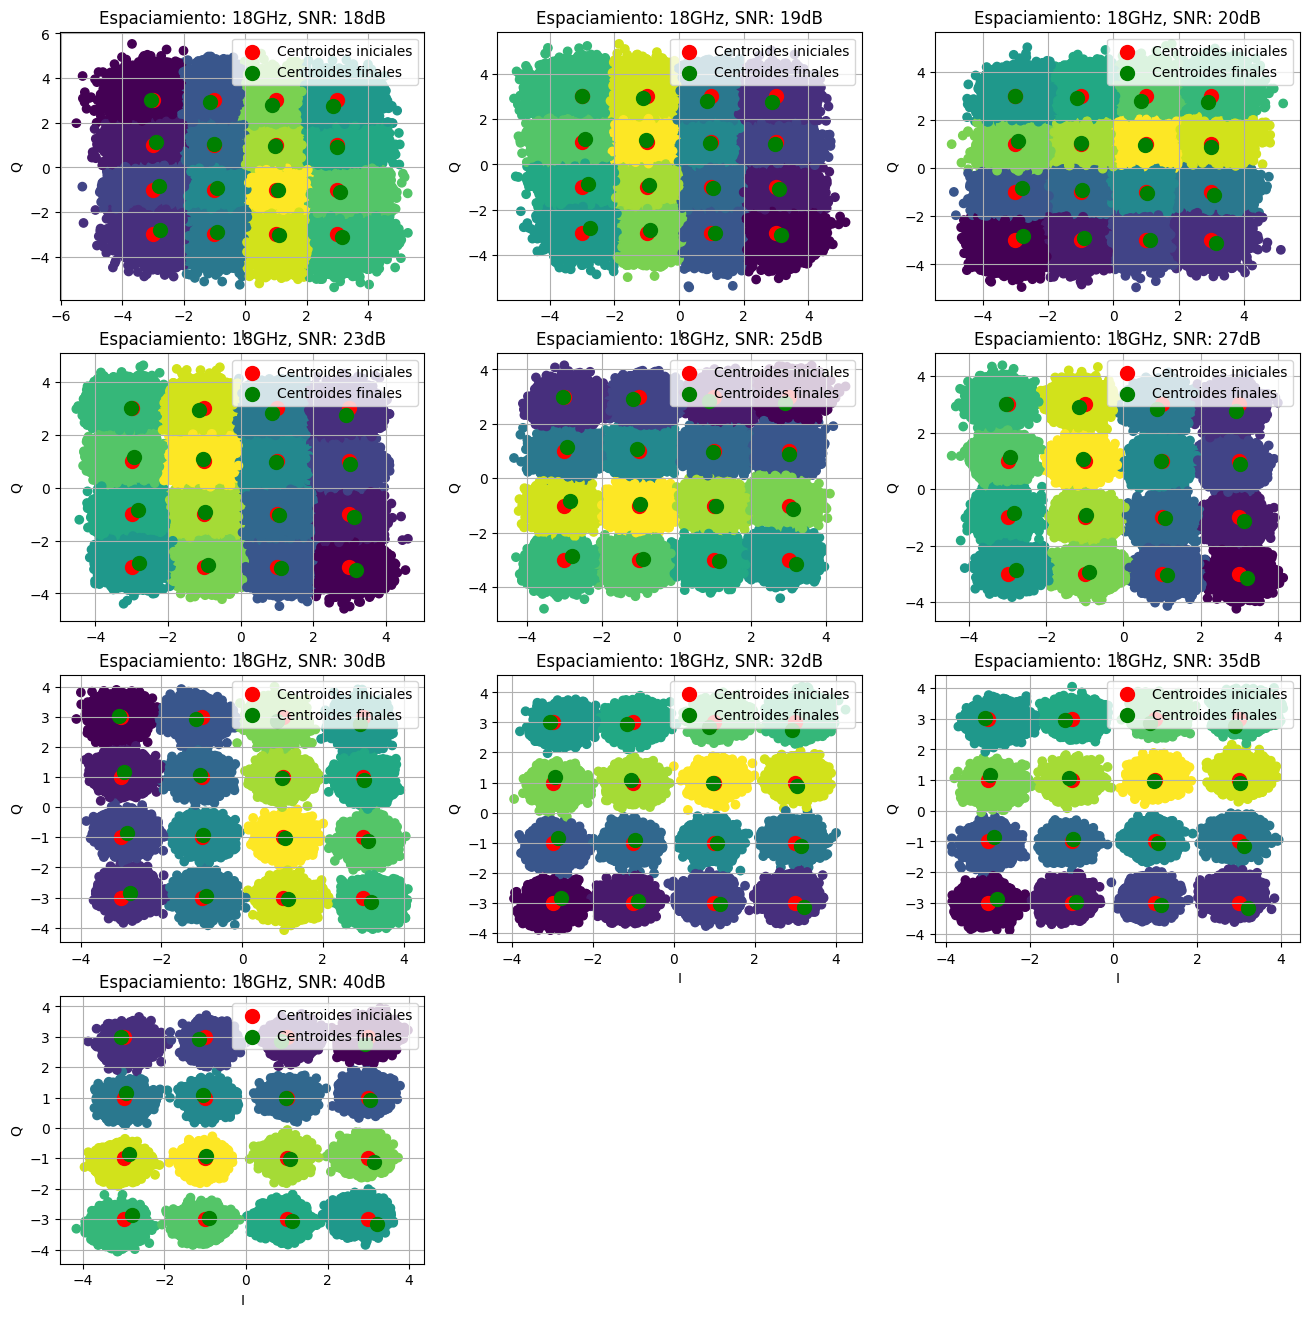

In [23]:
spacing = "18GHz_spacing"

ber = {}

plt.figure(figsize = (16, 16))

for i, snr in enumerate(data[spacing]):
    # Extraer información
    X_ch_norm = data[spacing][snr].get("const_Y").flatten()
    X_ch = sofa.mod_norm(X_ch_norm, 10)*X_ch_norm
    Xr_ch = X_ch.real
    Xi_ch = X_ch.imag
    Xr_tx = X_tx.real
    Xi_tx = X_tx.imag

    # Demodular
    X = X_ch.T
    signals = []
    kmeans_ber = []
    trad_ber = []
    
    for ph in range(4):
        # Constelación recibida rotada
        rotated_X = X_ch*np.exp(ph*1j*np.pi/2)
        # Sincronización de las señales
        synced_X_tx = sofa.sync_signals(X_tx, rotated_X)
        # Se demodula la señal transmitida
        y = sofa.demodulate(synced_X_tx, sofa.MOD_DICT)
        # Demodulación de la recibida rotada
        kmeans_model = sofa.demodulate_kmeans(rotated_X, sofa.MOD_DICT)
        kmeans = kmeans_model.predict(list(zip(rotated_X.real, rotated_X.imag)))
        trad = sofa.demodulate(rotated_X, sofa.MOD_DICT)
        # BER de la demodulación con respecto a la transmitida desplazada
        kmeans_ber.append(sofa.bit_error_rate(kmeans, y)[0])
        trad_ber.append(sofa.bit_error_rate(trad, y)[0])
        signals.append((rotated_X, synced_X_tx, y, kmeans_model))

    true_index = np.where(kmeans_ber == np.amin(kmeans_ber))[0][0]
    rotated_X, synced_X_tx, y, kmeans_model = signals[true_index]
    
    ber[snr] = {"kmeans": kmeans_ber[true_index],
                "trad": trad_ber[true_index]}

    # Probar la correlación con los datos sin demodular
    # Probar girando 90° la constelación recibida
    
    # Graficar
    plt.subplot(4, 3, i + 1)

    # Constelación transmitida
    plt.scatter(Xr_ch, Xi_ch, c = kmeans_model.labels_, marker = 'o')
    
    A_mc = np.array([(x.real, x.imag) for x in list(sofa.MOD_DICT.values())])
    
    plt.scatter(A_mc[:,0], A_mc[:,1],
                s = 100, label = "Centroides iniciales",
                marker = 'o', color = "red")
    
    plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1],
                s = 100, label = "Centroides finales",
                marker = 'o', color = "green")
    
    plt.title(f"Espaciamiento: {spacing.split('_')[0]}, SNR: {snr[5:]}")
    plt.legend(loc = "upper right")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid(True)
    # Mensaje para saber que se progresa
    print(f"SNR {snr[5:]} terminado.")
plt.show()

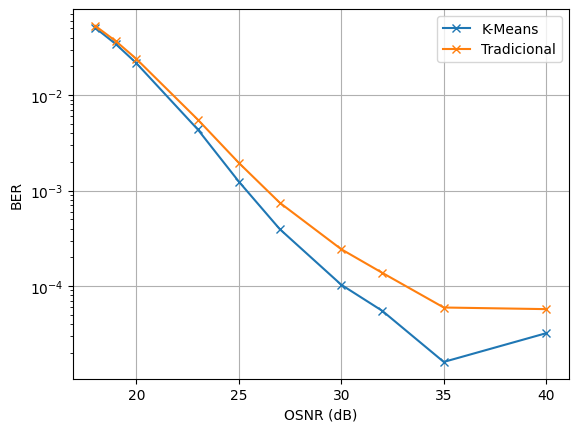

In [27]:
snr = [18, 19, 20, 23, 25, 27, 30, 32, 35, 40]
kBER = [ber.get(f"consY{snr_i}dB").get("kmeans") for snr_i in snr]
tBER = [ber.get(f"consY{snr_i}dB").get("trad") for snr_i in snr]
plt.semilogy(snr, kBER, marker = "x", label = "K-Means")
plt.semilogy(snr, tBER, marker = "x", label = "Tradicional")
plt.xlabel("OSNR (dB)")
plt.ylabel("BER")
plt.grid()
plt.legend(loc = "upper right")
plt.show()

## Falsificación del modelo real

In [ ]:
# Crear datos aleatorios
# Número de símbolos
Ns = 10000
# 16-QAM
Mod = 16
sym_tx = np.random.randint(Mod, size = Ns)

# Ahora se concatena 3 veces el array (simulando que sea infinito)
sym_tx_inf = np.concatenate((sym_tx, sym_tx))

# Ahora se tomará la longitud Ns del arreglo infinito desde un índice aleatorio
rand_index = np.random.randint(1, Ns*2 - 1)
print(f"El verdadero retraso es de {Ns - rand_index} posiciones")
sym_rx_pure = sym_tx_inf[rand_index:rand_index + Ns]

# Se modulará tanto la transmitida como la recibida
X_rx_pure = np.array([sofa.MOD_DICT[sym] for sym in sym_rx_pure])
X_tx = np.array([sofa.MOD_DICT[sym] for sym in sym_tx_inf])

snr = 24
X_ch_r, X_ch_i = sofa.add_awgn(snr, X_rx_pure)
X_ch = X_ch_r + 1j*X_ch_i

# Ahora finalmente se rotará la constelación
X_ch = X_ch*np.exp(2*1j*np.pi/2)

# Se grafica la constelación resultante
plt.scatter(X_ch.real, X_ch.imag)

# Se procede entonces a demodular (hacer el procedimiento inverso)
X = X_ch.T
kmeans_ser = []
trad_ser = []
for ph in range(4):
    # Constelación recibida rotada
    rotated_X = X_ch*np.exp(ph*1j*np.pi/2)
    # Sincronización de las señales
    rotated_X, synced_X_tx = sofa.sync_signals(rotated_X, X_tx)
    print(f"El error absoluto entre las señales sincronizadas es {np.abs(rotated_X[:5] - synced_X_tx[:5])}")
    # Se demodula la señal transmitida
    y = sofa.demodulate(synced_X_tx, sofa.MOD_DICT)
    print(y[:5])
    # Demodulación de la recibida rotada
    kmeans = sofa.demodulate_kmeans(rotated_X, sofa.MOD_DICT)
    trad = sofa.demodulate(rotated_X, sofa.MOD_DICT)
    # BER de la demodulación con respecto a la transmitida desplazada
    kmeans_ser.append(sofa.symbol_error_rate(kmeans, y))
    trad_ser.append(sofa.symbol_error_rate(trad, y))

print(kmeans_ser)
print(trad_ser)
# Probar la correlación con los datos sin demodular
# Probar girando 90° la constelación recibida